In [1]:
import pandas as pd
df = pd.read_csv('./data.csv', skiprows=1)
df_traffic = pd.read_csv('./Camera_Traffic_Counts2_20250918.csv')

In [2]:
df.columns, df_traffic.columns

(Index(['Date', 'TAVG (Degrees Fahrenheit)', 'TMAX (Degrees Fahrenheit)',
        'TMIN (Degrees Fahrenheit)', 'PRCP (Inches)', 'SNOW (Inches)',
        'SNWD (Inches)'],
       dtype='object'),
 Index(['Record ID', 'ATD Device ID', 'Read Date', 'Intersection Name',
        'Direction', 'Movement', 'Heavy Vehicle', 'Volume',
        'Speed Average (Miles Per Hour)', 'Speed StdDev',
        'Seconds in Zone Average', 'Seconds in Zone StdDev', 'Month', 'Day',
        'Year', 'Hour', 'Minute', 'Day of Week', 'Bin Duration (Seconds)'],
       dtype='object'))

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [4]:
df.head()

,Date,TAVG (Degrees Fahrenheit),TMAX (Degrees Fahrenheit),TMIN (Degrees Fahrenheit),PRCP (Inches),SNOW (Inches),SNWD (Inches)
0,1948-03-01,NaN,81.0,67.0,0.05,0.0,0.0
1,1948-03-02,NaN,72.0,46.0,0.07,0.0,0.0
2,1948-03-03,NaN,65.0,43.0,0.00,0.0,0.0
3,1948-03-04,NaN,60.0,48.0,0.00,0.0,0.0
4,1948-03-05,NaN,49.0,40.0,0.04,0.0,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28349 entries, 0 to 28348
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       28349 non-null  object 
 1   TAVG (Degrees Fahrenheit)  7200 non-null   float64
 2   TMAX (Degrees Fahrenheit)  19504 non-null  float64
 3   TMIN (Degrees Fahrenheit)  19446 non-null  float64
 4   PRCP (Inches)              19323 non-null  float64
 5   SNOW (Inches)              18794 non-null  float64
 6   SNWD (Inches)              18882 non-null  float64
dtypes: float64(6), object(1)
memory usage: 1.5+ MB


In [6]:
df.describe()

,TAVG (Degrees Fahrenheit),TMAX (Degrees Fahrenheit),TMIN (Degrees Fahrenheit),PRCP (Inches),SNOW (Inches),SNWD (Inches)
count,7200.000000,19504.000000,19446.000000,19323.000000,18794.000000,18882.000000
mean,68.957500,80.029430,57.189139,0.090655,0.001852,0.002341
std,14.290028,14.960902,15.399807,0.378450,0.078027,0.101880
min,16.000000,20.000000,-5.000000,0.000000,0.000000,0.000000
25%,58.000000,70.000000,45.000000,0.000000,0.000000,0.000000
50%,72.000000,82.000000,60.000000,0.000000,0.000000,0.000000
75%,81.000000,92.000000,71.000000,0.000000,0.000000,0.000000
max,93.000000,112.000000,82.000000,12.490000,6.100000,6.000000


In [7]:
df_traffic.head()

,Record ID,ATD Device ID,Read Date,Intersection Name,Direction,Movement,Heavy Vehicle,Volume,Speed Average (Miles Per Hour),Speed StdDev,Seconds in Zone Average,Seconds in Zone StdDev,Month,Day,Year,Hour,Minute,Day of Week,Bin Duration (Seconds)
0,595bf8744b9dd96b150f2fff20d9a315,6549,11/07/2019 12:00:00 AM,WEST GATE BLVD / JONES RD,EASTBOUND,LEFT TURN,True,1,11.0,0.000,3.800,0.000,11,7,2019,0,0,4,900
1,78739969a39bc2a116e12718a1bb3f5b,6549,11/07/2019 12:00:00 AM,WEST GATE BLVD / JONES RD,NORTHBOUND,LEFT TURN,False,1,8.0,0.000,0.100,0.000,11,7,2019,0,0,4,900
2,1cd581df7936da3ff89de600aa45b6b4,6549,11/07/2019 12:00:00 AM,WEST GATE BLVD / JONES RD,NORTHBOUND,THRU,False,9,27.0,5.766,1.811,0.697,11,7,2019,0,0,4,900
3,fbc38f488bd0b35d01e7c55deaff16c8,6549,11/07/2019 12:00:00 AM,WEST GATE BLVD / JONES RD,NORTHBOUND,THRU,True,2,32.0,4.243,1.850,0.071,11,7,2019,0,0,4,900
4,40e1f863f1aacc15f4c6ada55b59839f,6549,11/07/2019 12:00:00 AM,WEST GATE BLVD / JONES RD,SOUTHBOUND,LEFT TURN,False,1,12.0,0.000,2.700,0.000,11,7,2019,0,0,4,900


In [8]:
print(df['Date'].dtype)
print(df_traffic['Read Date'].dtype)

object
object


In [9]:
df_final = pd.concat([df.reset_index(drop=True), df_traffic.reset_index(drop=True)], axis=1)
df_final.head()

,Date,TAVG (Degrees Fahrenheit),TMAX (Degrees Fahrenheit),TMIN (Degrees Fahrenheit),PRCP (Inches),SNOW (Inches),SNWD (Inches),Record ID,ATD Device ID,Read Date,...,Speed StdDev,Seconds in Zone Average,Seconds in Zone StdDev,Month,Day,Year,Hour,Minute,Day of Week,Bin Duration (Seconds)
0,1948-03-01,NaN,81.0,67.0,0.05,0.0,0.0,595bf8744b9dd96b150f2fff20d9a315,6549,11/07/2019 12:00:00 AM,...,0.000,3.800,0.000,11,7,2019,0,0,4,900
1,1948-03-02,NaN,72.0,46.0,0.07,0.0,0.0,78739969a39bc2a116e12718a1bb3f5b,6549,11/07/2019 12:00:00 AM,...,0.000,0.100,0.000,11,7,2019,0,0,4,900
2,1948-03-03,NaN,65.0,43.0,0.00,0.0,0.0,1cd581df7936da3ff89de600aa45b6b4,6549,11/07/2019 12:00:00 AM,...,5.766,1.811,0.697,11,7,2019,0,0,4,900
3,1948-03-04,NaN,60.0,48.0,0.00,0.0,0.0,fbc38f488bd0b35d01e7c55deaff16c8,6549,11/07/2019 12:00:00 AM,...,4.243,1.850,0.071,11,7,2019,0,0,4,900
4,1948-03-05,NaN,49.0,40.0,0.04,0.0,0.0,40e1f863f1aacc15f4c6ada55b59839f,6549,11/07/2019 12:00:00 AM,...,0.000,2.700,0.000,11,7,2019,0,0,4,900


In [10]:
df_final.columns

Index(['Date', 'TAVG (Degrees Fahrenheit)', 'TMAX (Degrees Fahrenheit)',
       'TMIN (Degrees Fahrenheit)', 'PRCP (Inches)', 'SNOW (Inches)',
       'SNWD (Inches)', 'Record ID', 'ATD Device ID', 'Read Date',
       'Intersection Name', 'Direction', 'Movement', 'Heavy Vehicle', 'Volume',
       'Speed Average (Miles Per Hour)', 'Speed StdDev',
       'Seconds in Zone Average', 'Seconds in Zone StdDev', 'Month', 'Day',
       'Year', 'Hour', 'Minute', 'Day of Week', 'Bin Duration (Seconds)'],
      dtype='object')

In [11]:
for col in df_final.columns:
    print(repr(col))

'Date'
'TAVG (Degrees Fahrenheit)'
'TMAX (Degrees Fahrenheit)'
'TMIN (Degrees Fahrenheit)'
'PRCP (Inches)'
'SNOW (Inches)'
'SNWD (Inches)'
'Record ID'
'ATD Device ID'
'Read Date'
'Intersection Name'
'Direction'
'Movement'
'Heavy Vehicle'
'Volume'
'Speed Average (Miles Per Hour)'
'Speed StdDev'
'Seconds in Zone Average'
'Seconds in Zone StdDev'
'Month'
'Day'
'Year'
'Hour'
'Minute'
'Day of Week'
'Bin Duration (Seconds)'


In [12]:
df_final.isna().sum()

Date                              14689275
TAVG (Degrees Fahrenheit)         14710424
TMAX (Degrees Fahrenheit)         14698120
TMIN (Degrees Fahrenheit)         14698178
PRCP (Inches)                     14698301
SNOW (Inches)                     14698830
SNWD (Inches)                     14698742
Record ID                                0
ATD Device ID                            0
Read Date                                0
Intersection Name                        0
Direction                                0
Movement                                 0
Heavy Vehicle                            0
Volume                                   0
Speed Average (Miles Per Hour)           0
Speed StdDev                             0
Seconds in Zone Average                  0
Seconds in Zone StdDev                   0
Month                                    0
Day                                      0
Year                                     0
Hour                                     0
Minute     

In [13]:
df_final[['TAVG (Degrees Fahrenheit)', 'TMAX (Degrees Fahrenheit)', 
    'TMIN (Degrees Fahrenheit)', 'PRCP (Inches)', 
    'SNOW (Inches)', 'SNWD (Inches)']].isna().mean() * 100

TAVG (Degrees Fahrenheit)    99.951079
TMAX (Degrees Fahrenheit)    99.867479
TMIN (Degrees Fahrenheit)    99.867873
PRCP (Inches)                99.868708
SNOW (Inches)                99.872303
SNWD (Inches)                99.871705
dtype: float64

In [14]:
df_final.dropna(inplace=True)

In [15]:
df_final.isna().sum()

Date                              0
TAVG (Degrees Fahrenheit)         0
TMAX (Degrees Fahrenheit)         0
TMIN (Degrees Fahrenheit)         0
PRCP (Inches)                     0
SNOW (Inches)                     0
SNWD (Inches)                     0
Record ID                         0
ATD Device ID                     0
Read Date                         0
Intersection Name                 0
Direction                         0
Movement                          0
Heavy Vehicle                     0
Volume                            0
Speed Average (Miles Per Hour)    0
Speed StdDev                      0
Seconds in Zone Average           0
Seconds in Zone StdDev            0
Month                             0
Day                               0
Year                              0
Hour                              0
Minute                            0
Day of Week                       0
Bin Duration (Seconds)            0
dtype: int64

In [16]:
# Features (X)
X = df_final.drop(columns=['Intersection Name', 'Direction', 'Movement', 'Speed Average (Miles Per Hour)', 'Date', 'Record ID', 'Read Date'])

# Target (y)
y = df_final[['Speed Average (Miles Per Hour)']]


In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numeric_cols = ['PRCP (Inches)', 'SNOW (Inches)', 'TAVG (Degrees Fahrenheit)', 'Speed Average (Miles Per Hour)']

df_final[numeric_cols] = scaler.fit_transform(df_final[numeric_cols])

In [18]:
df_final.head()

,Date,TAVG (Degrees Fahrenheit),TMAX (Degrees Fahrenheit),TMIN (Degrees Fahrenheit),PRCP (Inches),SNOW (Inches),SNWD (Inches),Record ID,ATD Device ID,Read Date,...,Speed StdDev,Seconds in Zone Average,Seconds in Zone StdDev,Month,Day,Year,Hour,Minute,Day of Week,Bin Duration (Seconds)
18293,1998-04-01,-0.793505,79.0,36.0,-0.237598,-0.020685,0.0,43ee8657cf820657241344d7f28e5f09,6212,11/07/2019 10:00:00 PM,...,0.000,1.20,0.000,11,7,2019,22,0,4,900
18294,1998-04-02,-0.723472,78.0,39.0,-0.237598,-0.020685,0.0,6ea81212e5b8fcc7ad5274662e7b8984,6212,11/07/2019 10:00:00 PM,...,5.459,14.56,15.838,11,7,2019,22,0,4,900
18295,1998-04-03,-0.443337,79.0,46.0,-0.237598,-0.020685,0.0,25d3cb333f5863eea025bc83a713245c,6212,11/07/2019 10:00:00 PM,...,0.000,12.20,0.000,11,7,2019,22,0,4,900
18296,1998-04-04,-0.793505,72.0,43.0,-0.237598,-0.020685,0.0,b26a28231e36021dc0a3f458bcf3cfa8,6212,11/07/2019 10:00:00 PM,...,2.828,2.70,3.677,11,7,2019,22,0,4,900
18297,1998-04-05,-0.723472,77.0,41.0,-0.237598,-0.020685,0.0,3c11a58ecabc3a5950c26066558caaab,6212,11/07/2019 10:00:00 PM,...,3.536,15.15,18.597,11,7,2019,22,0,4,900


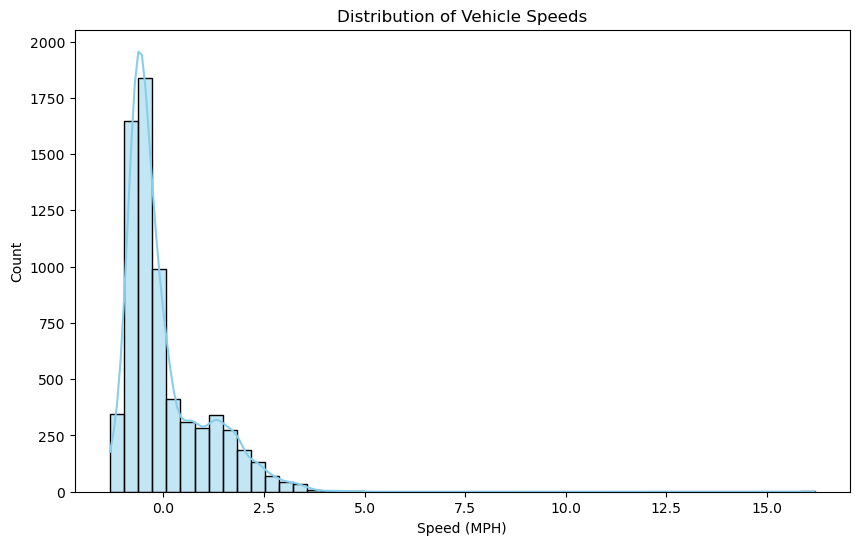

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.histplot(df_final['Speed Average (Miles Per Hour)'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Vehicle Speeds')
plt.xlabel('Speed (MPH)')
plt.ylabel('Count')
plt.show()


In [20]:

# Now create Precipitation_Type on the full dataframe
import numpy as np

df['Precipitation_Type'] = np.select(
    [
        df['SNOW (Inches)'] > 0,
        (df['PRCP (Inches)'] > 0) & (df['SNOW (Inches)'] == 0)
    ],
    ['Snow', 'Rain'],
    default='No Precipitation'
)

# Check counts
print(df['Precipitation_Type'].value_counts())


Precipitation_Type
No Precipitation    24304
Rain                 4021
Snow                   24
Name: count, dtype: int64


In [21]:
df_final[df_final['PRCP (Inches)'] > 0]['PRCP (Inches)'].value_counts()


PRCP (Inches)
0.094866     29
0.023624     28
0.284845     23
0.142361     22
0.047371     21
             ..
4.250663      1
5.865487      1
2.659587      1
10.116274     1
2.897061      1
Name: count, Length: 212, dtype: int64

In [22]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6920 entries, 18293 to 28300
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Date                            6920 non-null   object 
 1   TAVG (Degrees Fahrenheit)       6920 non-null   float64
 2   TMAX (Degrees Fahrenheit)       6920 non-null   float64
 3   TMIN (Degrees Fahrenheit)       6920 non-null   float64
 4   PRCP (Inches)                   6920 non-null   float64
 5   SNOW (Inches)                   6920 non-null   float64
 6   SNWD (Inches)                   6920 non-null   float64
 7   Record ID                       6920 non-null   object 
 8   ATD Device ID                   6920 non-null   int64  
 9   Read Date                       6920 non-null   object 
 10  Intersection Name               6920 non-null   object 
 11  Direction                       6920 non-null   object 
 12  Movement                        69

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [24]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((5536, 19), (1384, 19), (5536, 1), (1384, 1))

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score

lr = LinearRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(lr, X_train, y_train, cv=kf, scoring='r2')
print("Linear Regression CV R2 scores:", cv_scores)
print("Mean CV R2:", cv_scores.mean())


Linear Regression CV R2 scores: [0.39863513 0.43118772 0.33406755 0.37795213 0.38977792]
Mean CV R2: 0.3863240899583653


In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(rf, param_grid, cv=kf, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV R2:", grid_search.best_score_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Applications/anaconda3/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Applications/anaconda3/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Applications/anaconda3/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Applications/anaconda3/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best CV R2: 0.7519102711444543


In [27]:
from sklearn.metrics import r2_score, mean_squared_error

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

print("Test R2:", r2_score(y_test, y_pred))
print("Test RMSE:", mean_squared_error(y_test, y_pred))


Test R2: 0.8092294945610747
Test RMSE: 50.53244759216497


In [28]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define the model
gbr = GradientBoostingRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit the model
grid_search.fit(X_train, y_train.values.ravel())

# Get best model
best_gbr = grid_search.best_estimator_

# Evaluate
y_pred = best_gbr.predict(X_test)
test_r2 = r2_score(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Best Parameters:", grid_search.best_params_)
print("Best CV R2:", grid_search.best_score_)
print("Test R2:", test_r2)
print("Test RMSE:", test_rmse)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   8.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   6.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   7.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  13.9s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.7s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   6.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   9.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   8.5s
[CV] END max_de

In [29]:
# Step 1: Install CodeCarbon if you haven't yet
!pip install codecarbon

# Step 2: Import dependencies
from codecarbon import EmissionsTracker
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Step 3: Split your dataset (assuming X_train, X_test, y_train, y_test already exist)

# ------------------------
# Random Forest Regressor
# ------------------------
tracker_rf = EmissionsTracker(project_name="RandomForest_Regressor")
tracker_rf.start()

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_leaf=2,
    min_samples_split=2,
    random_state=42
)
rf.fit(X_train, y_train)

tracker_rf.stop()

y_pred_rf = rf.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)

print(f"Random Forest RMSE: {rf_rmse:.4f}, R²: {rf_r2:.4f}")

# ------------------------
# Gradient Boosting Regressor
# ------------------------
tracker_gbr = EmissionsTracker(project_name="GradientBoosting_Regressor")
tracker_gbr.start()

gbr = GradientBoostingRegressor(
    learning_rate=0.05,
    max_depth=7,
    min_samples_leaf=4,
    min_samples_split=10,
    n_estimators=100,
    random_state=42
)
gbr.fit(X_train, y_train)

tracker_gbr.stop()

y_pred_gbr = gbr.predict(X_test)
gbr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
gbr_r2 = r2_score(y_test, y_pred_gbr)

print(f"Gradient Boosting RMSE: {gbr_rmse:.4f}, R²: {gbr_r2:.4f}")


[codecarbon WARNING @ 15:42:26] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 15:42:26] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon INFO @ 15:42:26] [setup] RAM Tracking...
[codecarbon INFO @ 15:42:26] [setup] CPU Tracking...
[codecarbon WARNING @ 15:42:26] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 15:42:26] CPU Model on constant consumption mode: Apple M1
[codecarbon WARNING @ 15:42:26] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:42:26] [setup] GPU Tracking...
[codecarbon INFO @ 15:42:27] No GPU found.
[codecarbon INFO @ 15:42:27] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant


Random Forest RMSE: 7.1086, R²: 0.8092


[codecarbon WARNING @ 15:42:37] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 15:42:37] CPU Model on constant consumption mode: Apple M1
[codecarbon WARNING @ 15:42:37] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:42:37] [setup] GPU Tracking...
[codecarbon INFO @ 15:42:37] No GPU found.
[codecarbon INFO @ 15:42:37] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:42:37] >>> Tracker's metadata:
[codecarbon INFO @ 15:42:37]   Platform system: macOS-15.2-arm64-arm-64bit-Mach-O
[codecarbon INFO @ 15:42:37]   Python version: 3.13.5
[codecarbon INFO @ 15:42:37]   CodeCarbon version: 3.0.7
[codecarbon INFO @ 15:42:37]   Availab

Gradient Boosting RMSE: 7.0462, R²: 0.8126


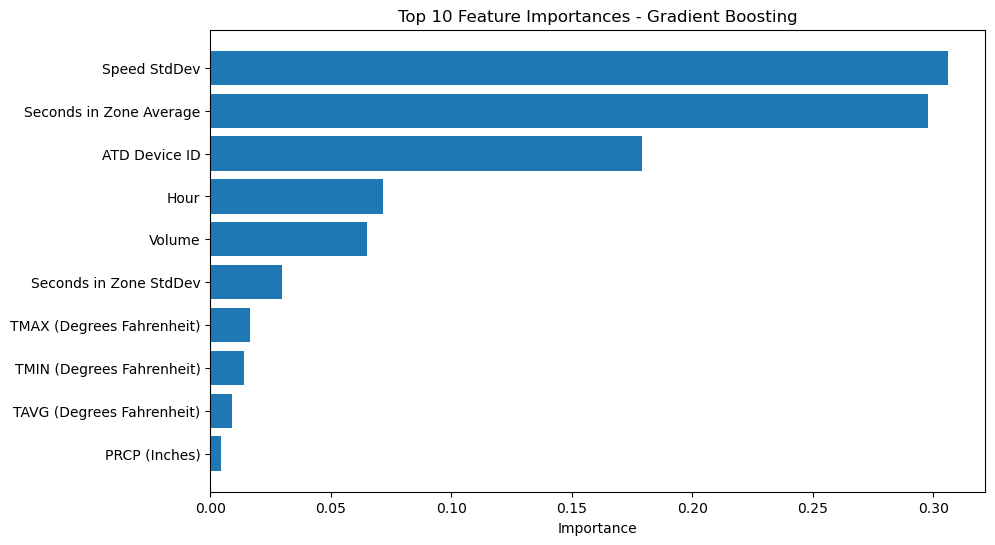

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Example using Gradient Boosting
feature_importances = best_gbr.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances - Gradient Boosting')
plt.show()


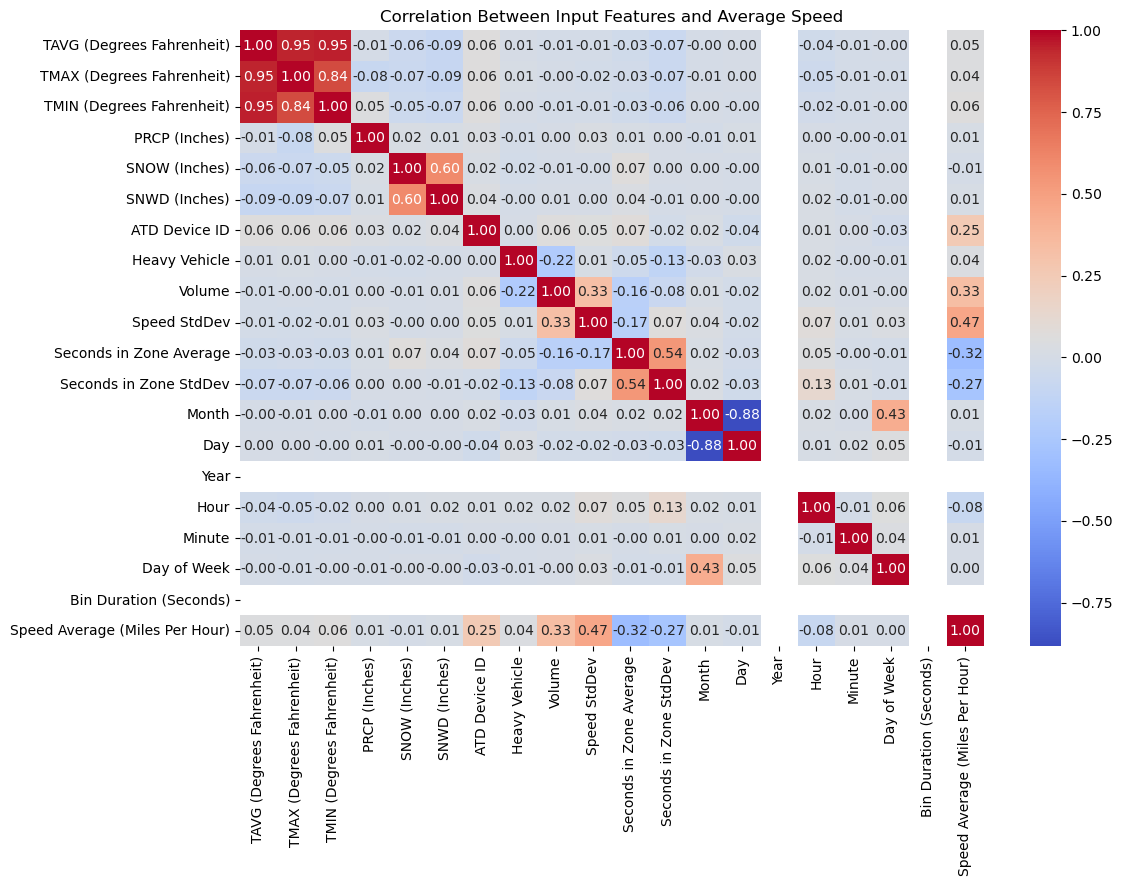

In [31]:
import seaborn as sns

# Correlation heatmap
corr = X.join(y).corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Between Input Features and Average Speed")
plt.show()


/Applications/anaconda3/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Applications/anaconda3/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Applications/anaconda3/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Applications/anaconda3/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

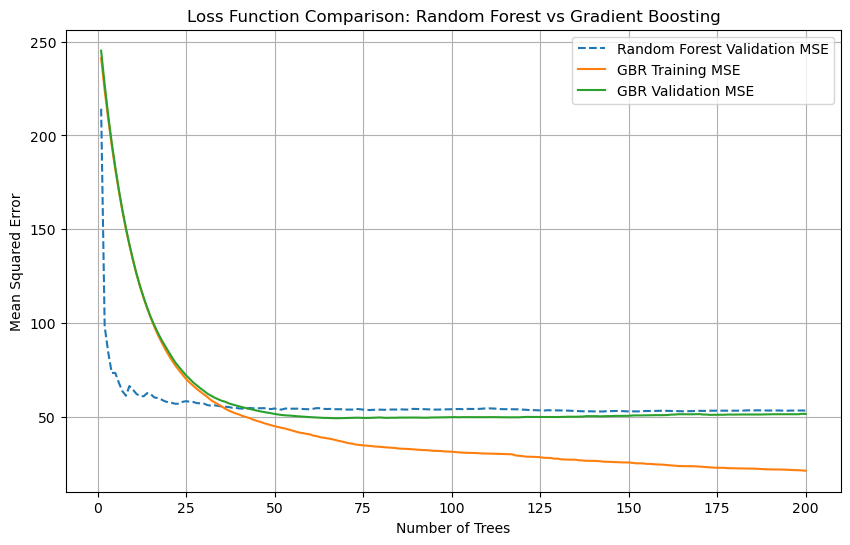

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Assuming your dataset is loaded as X, y
# (replace with your actual feature and target variables)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Random Forest Regressor ---
rf_losses = []
rf = RandomForestRegressor(n_estimators=1, warm_start=True, random_state=42)

for n_trees in range(1, 201):
    rf.set_params(n_estimators=n_trees)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rf_losses.append(mean_squared_error(y_val, y_pred))

# --- Gradient Boosting Regressor ---
gbr = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=7,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42
)
gbr.fit(X_train, y_train)

# Track loss across iterations
train_loss = np.array(gbr.train_score_)
val_loss = []

for y_pred in gbr.staged_predict(X_val):
    val_loss.append(mean_squared_error(y_val, y_pred))

# --- Plot both losses ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, 201), rf_losses, label='Random Forest Validation MSE', linestyle='--')
plt.plot(range(1, 201), train_loss, label='GBR Training MSE')
plt.plot(range(1, 201), val_loss, label='GBR Validation MSE')
plt.xlabel('Number of Trees')
plt.ylabel('Mean Squared Error')
plt.title('Loss Function Comparison: Random Forest vs Gradient Boosting')
plt.legend()
plt.grid(True)
plt.show()


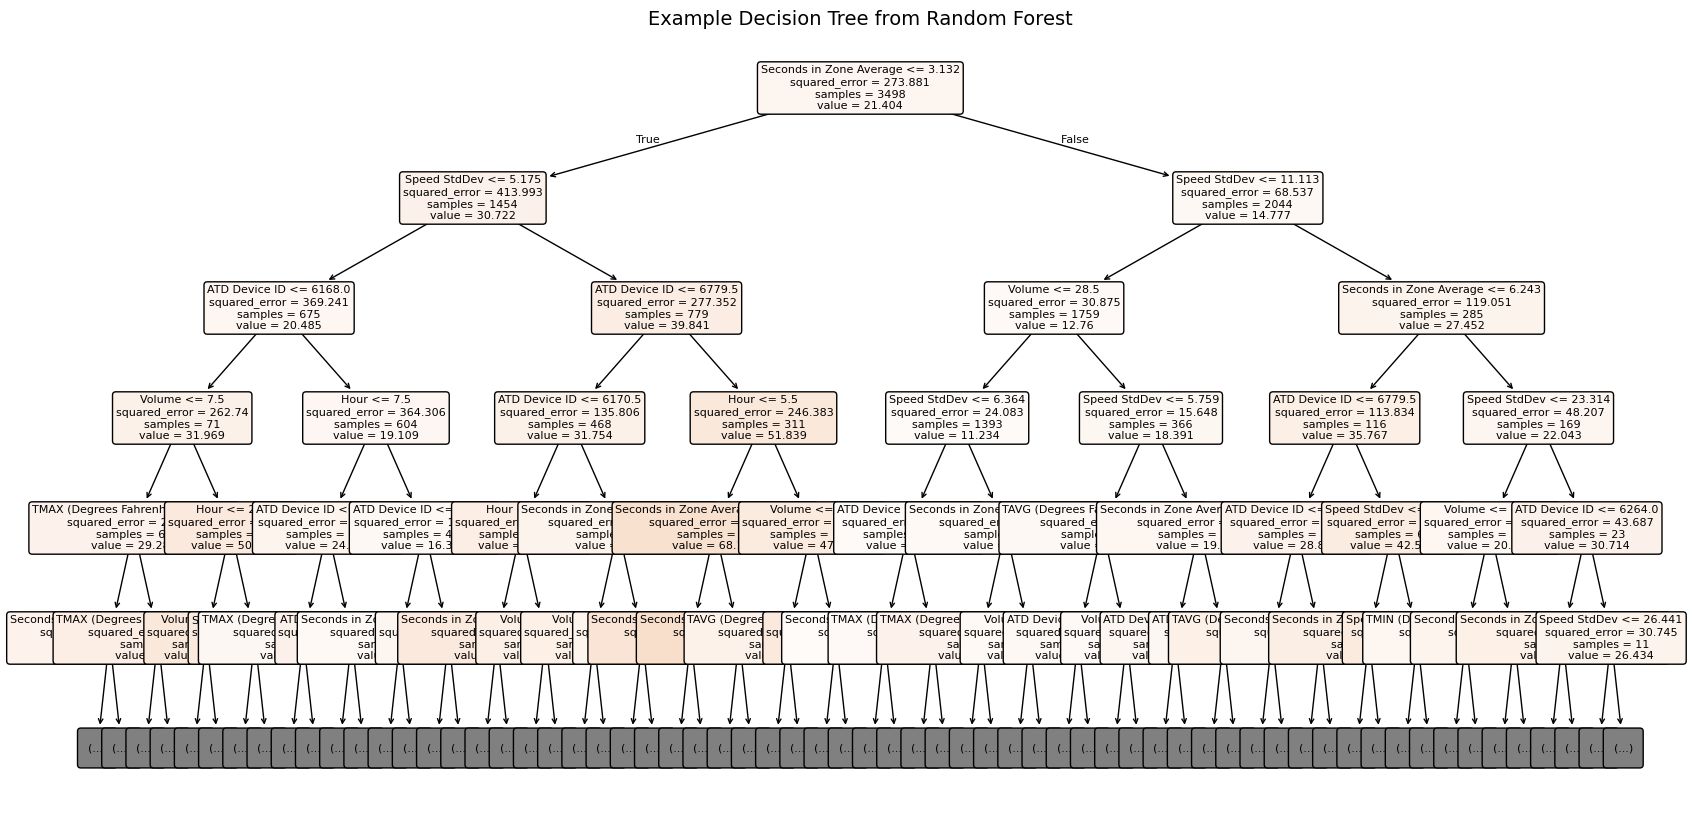

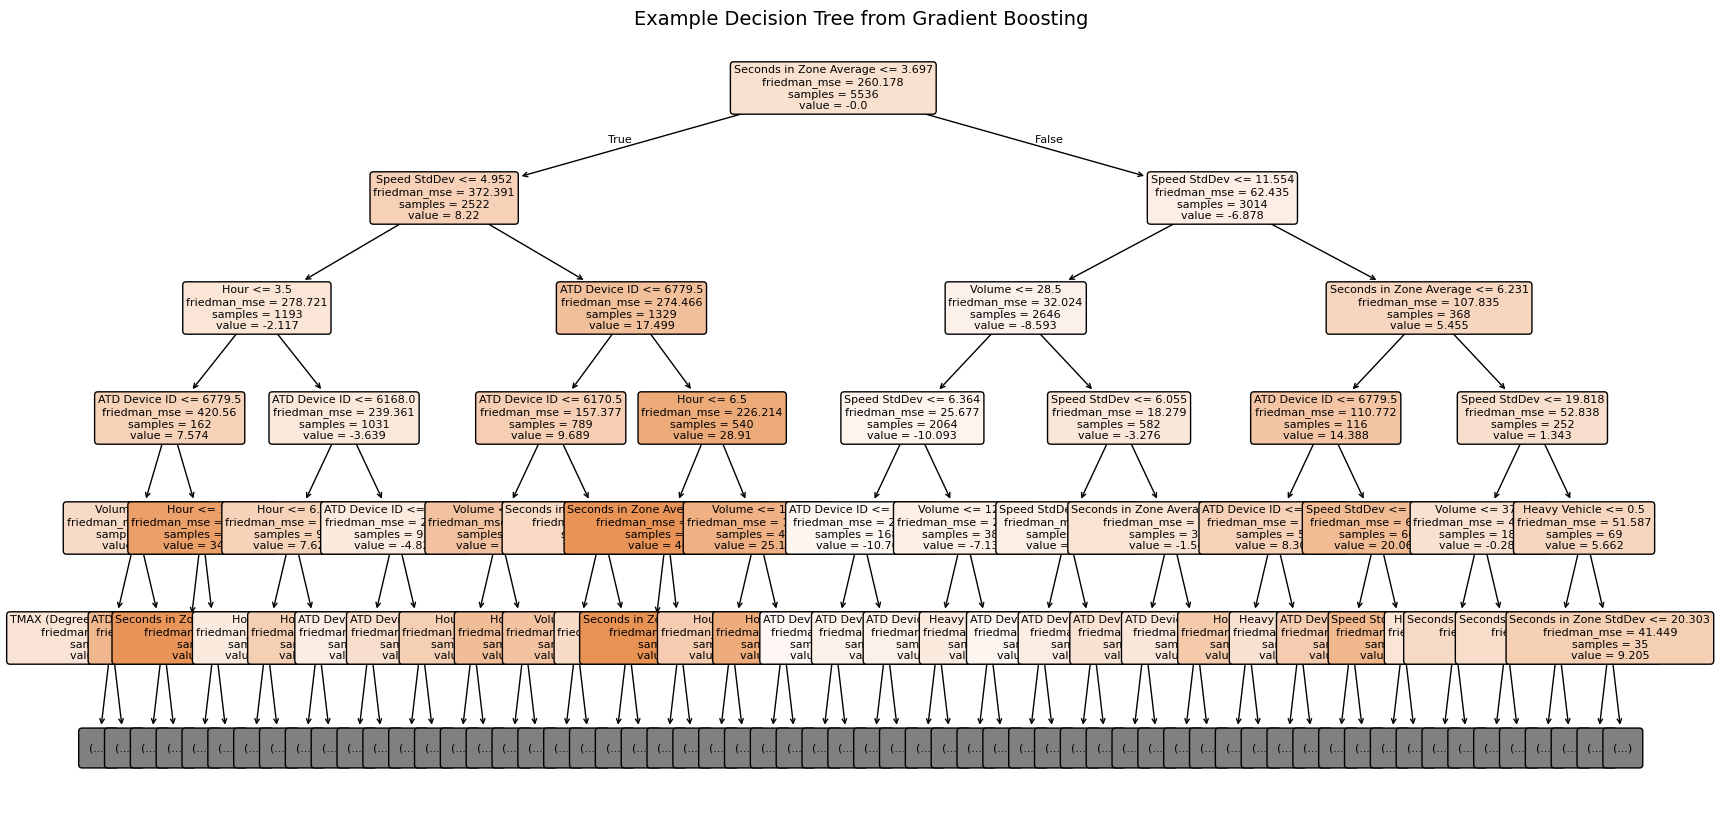

In [34]:
from sklearn import tree
import matplotlib.pyplot as plt

# Visualize a single tree from the Random Forest
plt.figure(figsize=(20,10))
tree.plot_tree(
    rf.estimators_[0],
    filled=True,
    max_depth = 5,
    feature_names=X.columns,
    rounded=True,
    fontsize=8
)
plt.title("Example Decision Tree from Random Forest", fontsize=14)
plt.show()

# Visualize a single tree from the Gradient Boosting Regressor
plt.figure(figsize=(20,10))
tree.plot_tree(
    gbr.estimators_[0, 0],
    filled=True,
    feature_names=X.columns,
    max_depth = 5,
    rounded=True,
    fontsize=8
)
plt.title("Example Decision Tree from Gradient Boosting", fontsize=14)
plt.show()
